In [17]:
import joblib
import sklearn

fold = 8
f = f'./output/run_20221112-121419/Cannabis_Dataset/model_DecisionTreeClassifier_{fold}.pickle'
dt = joblib.load(f)
print(dt)

GridSearchCV(cv=StratifiedKFold(n_splits=9, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scalar', MinMaxScaler()),
                                       ('selectkbest', SelectKBest(k=6)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__ccp_alpha': [0.015, 0.005,
                                                               0.01],
                         'decisiontreeclassifier__class_wei...
                                                               'log_loss'],
                         'decisiontreeclassifier__max_depth': [2, 3, 4, 5, 6],
                         'decisiontreeclassifier__max_features': ['sqrt', None],
                         'decisiontreeclassifier__min_samples_leaf': [1, 3, 5,
                               

In [18]:
dt.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scalar', MinMaxScaler()),
                ('selectkbest', SelectKBest(k=6)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.005,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=27, random_state=3))])

In [19]:
dt.best_estimator_['decisiontreeclassifier']

DecisionTreeClassifier(ccp_alpha=0.005, class_weight='balanced',
                       criterion='entropy', max_depth=4, min_samples_leaf=27,
                       random_state=3)

In [20]:
print(dt.best_estimator_['decisiontreeclassifier'].class_weight)

balanced


In [21]:
from sklearn.tree import DecisionTreeClassifier
from dataset.dataset_base import DrugDataset
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz
from dtreeviz.trees import dtreeviz # remember to load the package
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
from utils.scoring import compute_metrics

In [22]:
label = 'Cannabis'
ds = DrugDataset(file_path='data/drug_consumption.data',
                col_name=label)
num_features = 6

meth = 'rep-k-fold'
par = {'folds':10, 'repeats':2}


c_names = ['non-user','user']

In [23]:
# print feature importances
feat_importance = dt.best_estimator_['decisiontreeclassifier'].tree_.compute_feature_importances(normalize=False)
print("feat importance = " + str(feat_importance))

for f_ind, data in enumerate(ds.create_splits(method=meth, params=par)):
    if f_ind!=fold:
        continue
    train_x, _, _, _ = data
    f_names_filt = train_x.columns[dt.best_estimator_['selectkbest'].get_support()]

for name, imp in zip(f_names_filt,feat_importance):
    print(name," : ",imp)

feat importance = [0.0733398  0.1945152  0.02123059 0.01705874 0.         0.05079376]
Age  :  0.0733398012347298
Country  :  0.1945151965472212
Oscore  :  0.02123058893167583
Cscore  :  0.017058741095277274
Impulsive  :  0.0
SS  :  0.050793755151587176


C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


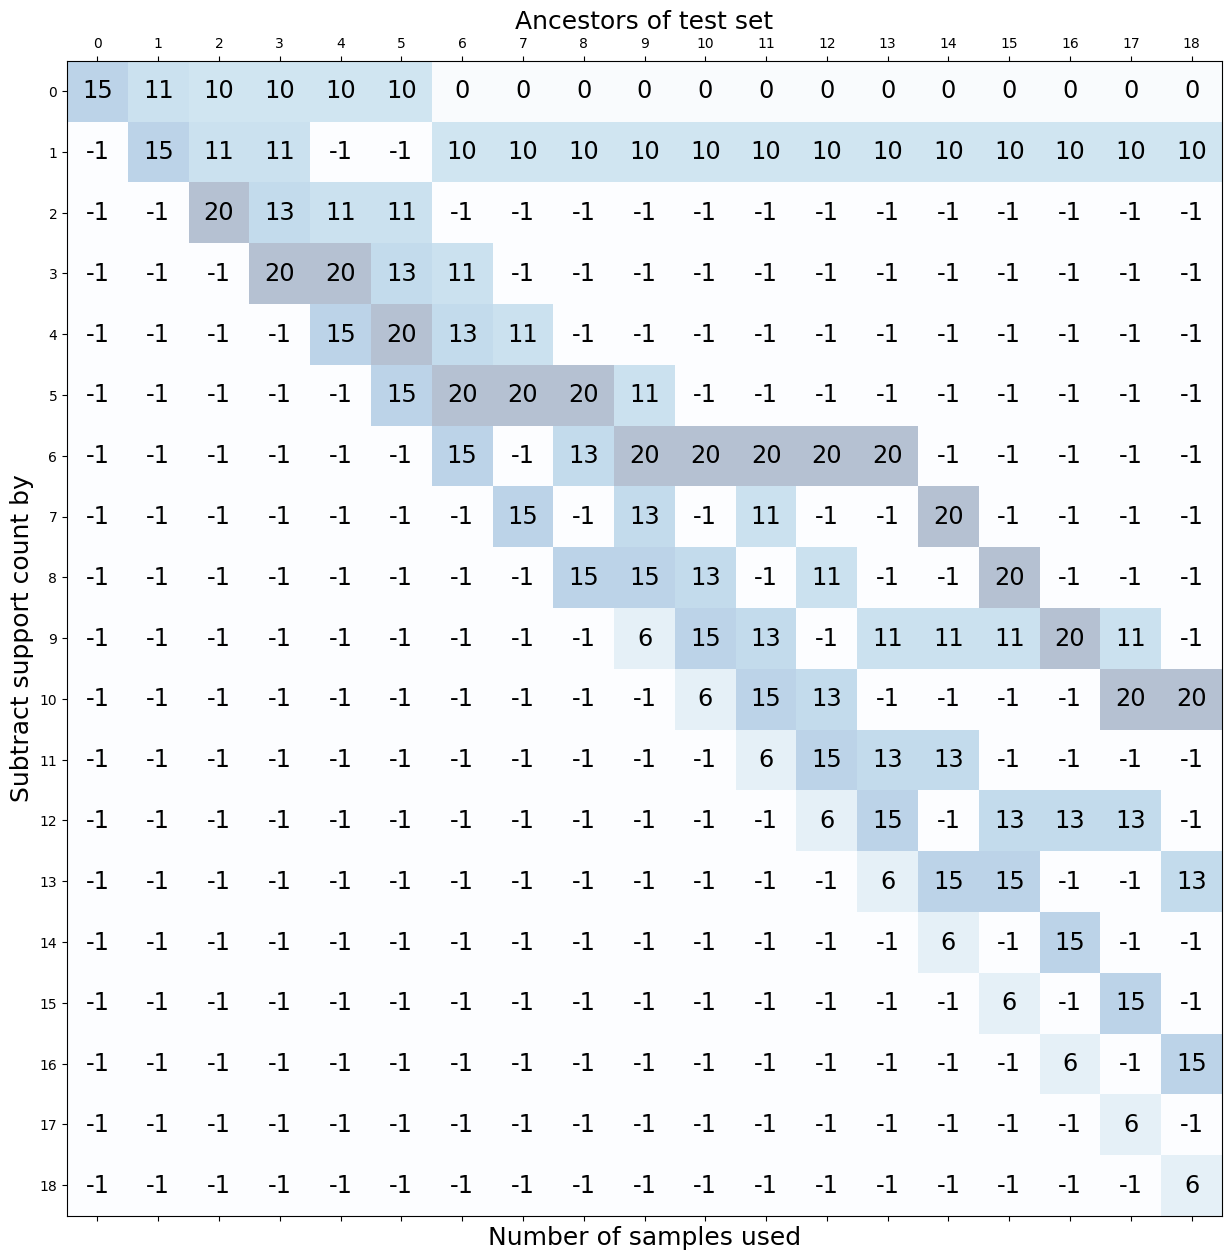

C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


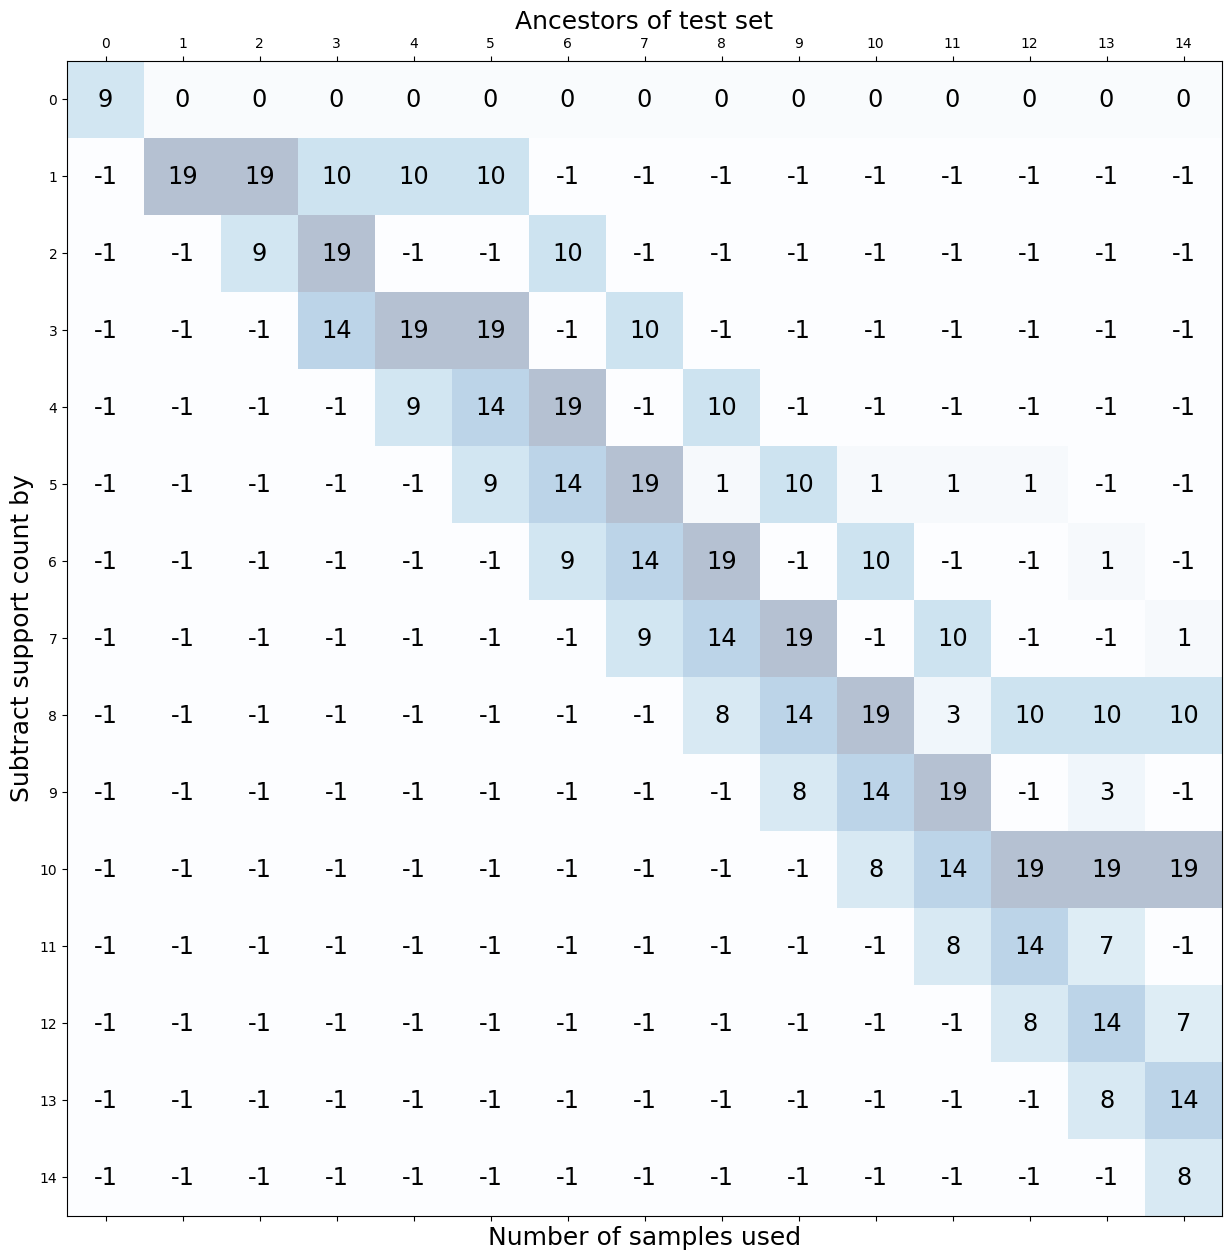

Precision:  0.8770491803278688
Recall:  0.8492063492063492
Negative Precision:  0.7121212121212122
f1:  0.8629032258064516
sensitivity(Recall):  0.8492063492063492
specificity(Negative Recall):  0.7580645161290323
gmean:  0.802342321085466
accuracy:  0.8191489361702128
macro_accuracy:  0.8036354326676907


C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


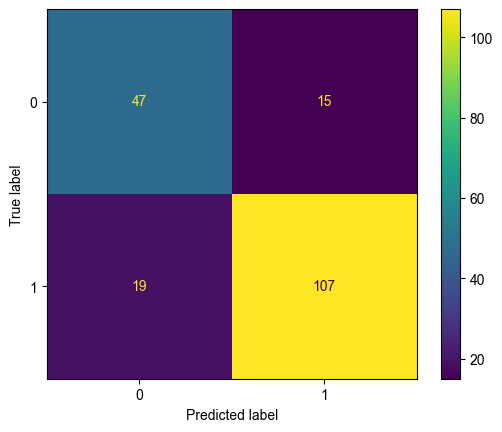

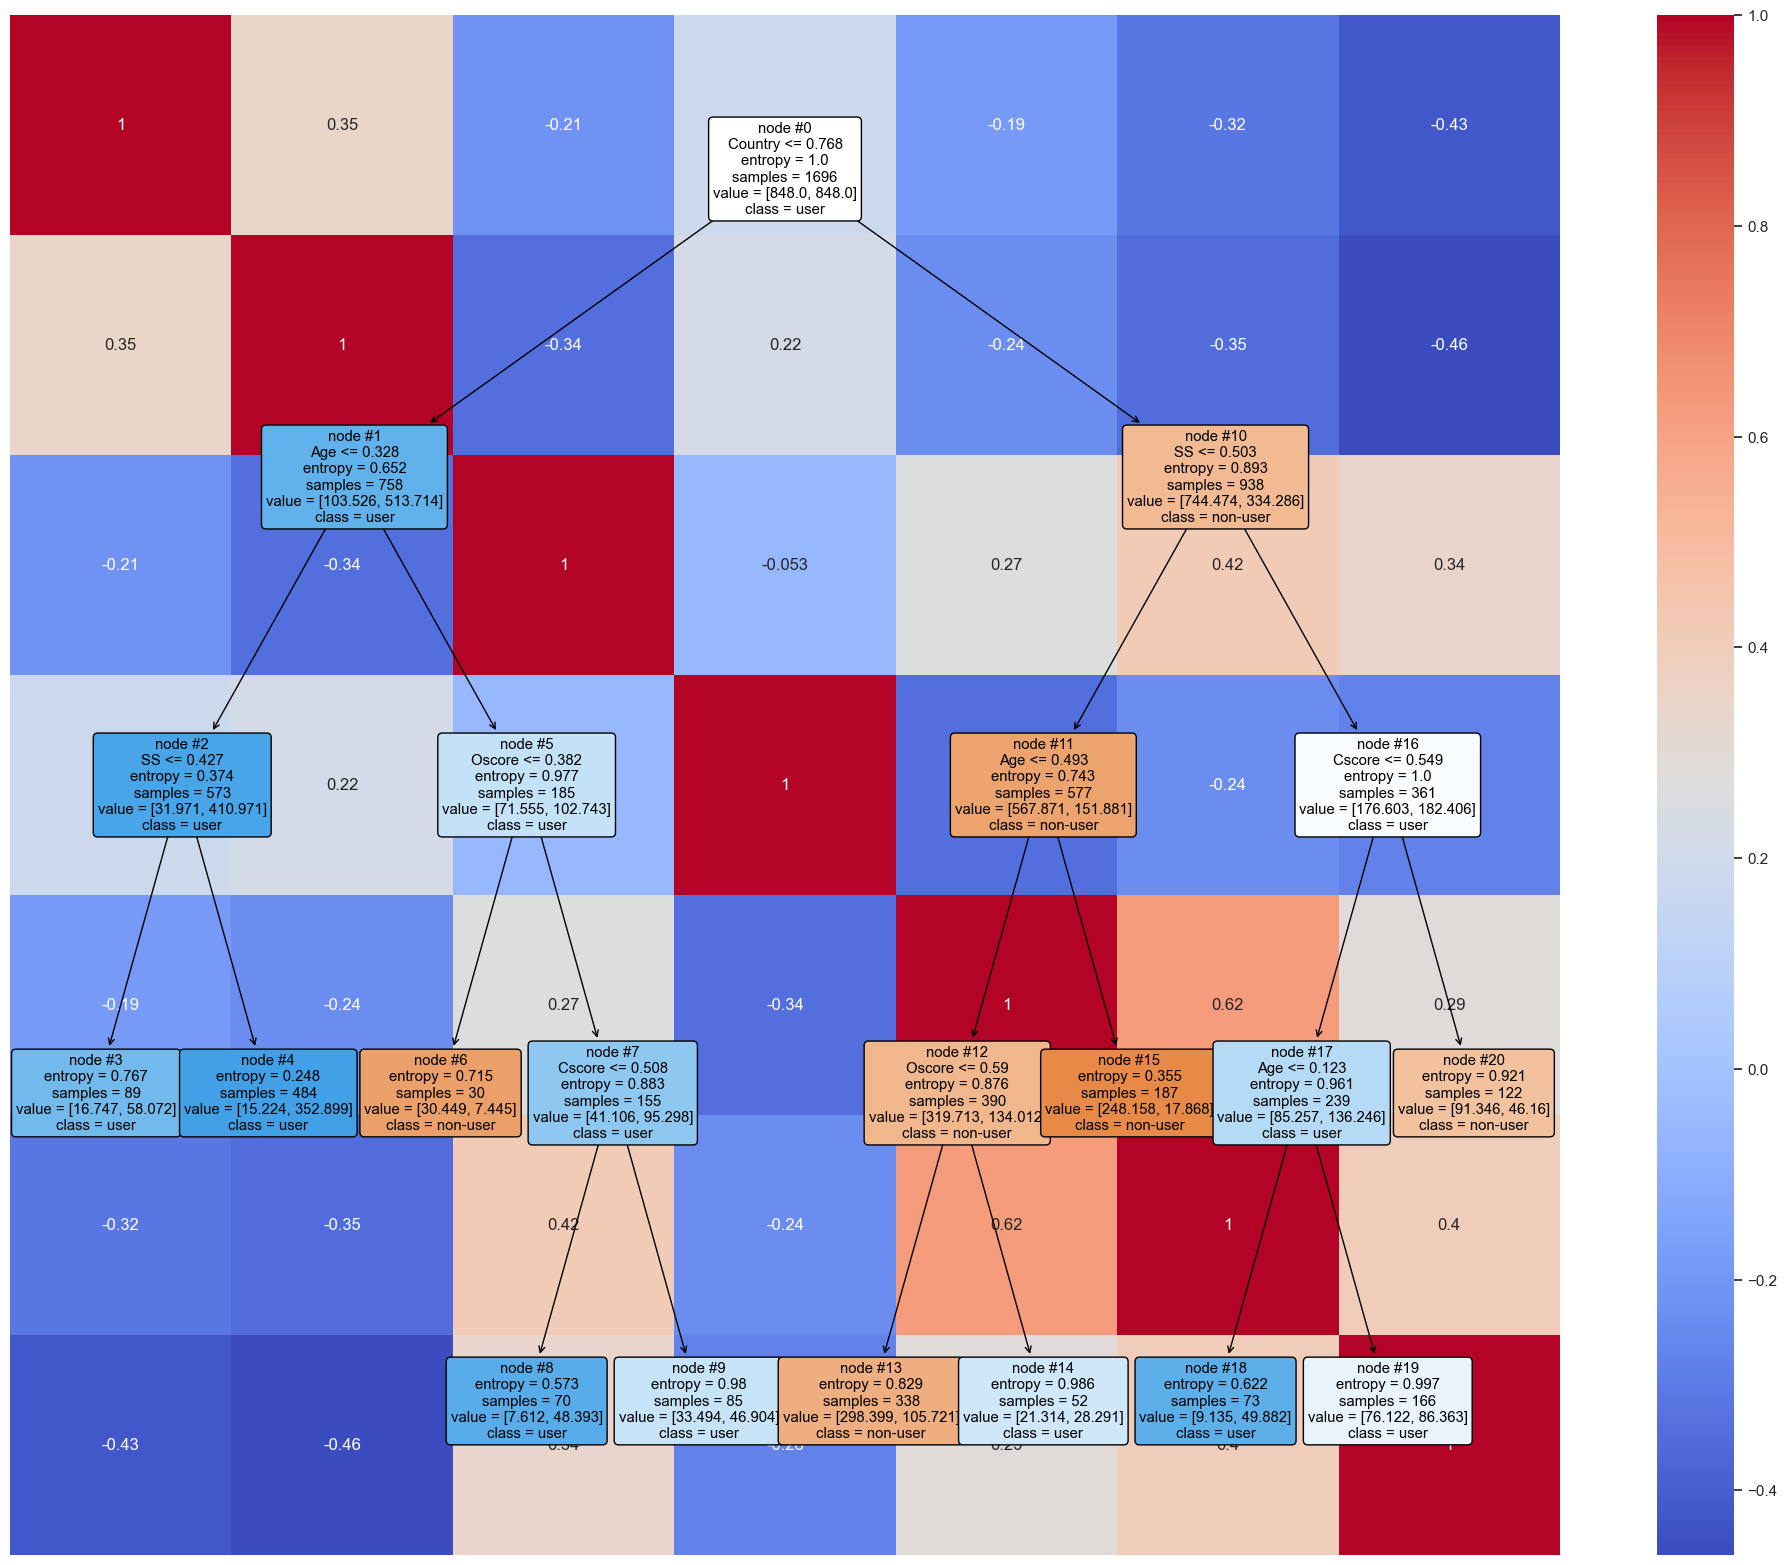

In [24]:
def plot_viz(dt,c_names,f_names,train_x,train_y,test_x,msg):
    test_x = dt.best_estimator_['scalar'].transform(test_x)
    test_x = dt.best_estimator_['selectkbest'].transform(test_x)
    
    max_test = 20
    for ind in range(len(test_x)):
        viz_test = dtreeviz(dt.best_estimator_['decisiontreeclassifier'], 
                           train_x, 
                           train_y,
                           target_name='label',
                           feature_names=f_names,
                           class_names=c_names,
                           X=test_x[ind])
        viz_test.save(f'analysis/DT_Analysis_{msg}/DT_{msg}_{ind}.svg')
        if ind>max_test:
            break


def get_common_anscestor(dt,test_set,file):
    test_xp = dt.best_estimator_['scalar'].transform(test_set)
    test_xp = dt.best_estimator_['selectkbest'].transform(test_xp)
    node_indicator = dt.best_estimator_['decisiontreeclassifier'].decision_path(test_xp)
    leaf_id = dt.best_estimator_['decisiontreeclassifier'].apply(test_xp)
    all_sample_ids = list(range(0,len(test_xp)))
    n_nodes = dt.best_estimator_['decisiontreeclassifier'].tree_.node_count
    
    plot_matrix = [[-1 for i in range(len(test_xp))] for j in range(len(test_xp))]
    for subset in range(len(all_sample_ids)):
        sample_ids = all_sample_ids[:subset+1]
        for sub in range(0,len(sample_ids)):
            common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0)==(len(sample_ids)-sub)
            common_node_id = np.arange(n_nodes)[common_nodes]
            str_rep = -1
            if len(common_node_id):
                str_rep = max([x for x in common_node_id])
            plot_matrix[sub][subset]=str_rep
            
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(plot_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(len(plot_matrix)):
        for j in range(len(plot_matrix[0])):
            ax.text(x=j, y=i,s=plot_matrix[i][j], va='center', ha='center', size='xx-large')
    plt.xlabel('Number of samples used', fontsize=18)
    plt.ylabel(f'Subtract support count by', fontsize=18)
    plt.xticks(list(range(len(test_xp))))
    plt.yticks(list(range(len(test_xp))))
    plt.title('Ancestors of test set', fontsize=18)
    plt.show()
            
for f_ind, data in enumerate(ds.create_splits(method=meth, params=par)):
    if f_ind!=fold:
        continue
    train_x, test_x, train_y, test_y = data
    f_names = train_x.columns
    f_names_filt = train_x.columns[dt.best_estimator_['selectkbest'].get_support()]
    
    
    # find positions where gt and pred differ
    preds = dt.best_estimator_.predict(test_x)
    preds_prob = dt.best_estimator_.predict_proba(test_x)[:,1]
    diff = test_y-preds
    summ = test_y+preds
    
    test_x_err_users = test_x.iloc[np.where(diff==1)]
    test_x_err_non_users = test_x.iloc[np.where(diff==-1)]
    
    test_x_corr_users = test_x.iloc[np.where(summ==2)]
    test_x_corr_non_users = test_x.iloc[np.where(summ==0)]
    
    
    get_common_anscestor(dt, test_x_err_users,'users_error.png')
    get_common_anscestor(dt, test_x_err_non_users, 'nonusers_error.png')
    # get_common_anscestor(dt, test_x_corr_users)
    # get_common_anscestor(dt, test_x_corr_non_users)

    
    metrics = compute_metrics(test_y, preds, preds_prob)
    print('Precision: ',metrics['precision'])
    print('Recall: ',metrics['recall'])
    print('Negative Precision: ',metrics['precision_n'])
    print('f1: ',metrics['f1'])
    print('sensitivity(Recall): ',metrics['sensitivity'])
    print('specificity(Negative Recall): ',metrics['specificity'])
    print('gmean: ',metrics['g_mean'])
    print('accuracy: ',metrics['micro_acc'])
    print('macro_accuracy: ',metrics['macro_acc'])
    
    
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt.best_estimator_['decisiontreeclassifier'], 
                       feature_names=f_names_filt,  
                       class_names=c_names,
                       rounded=True,
                       filled=True,
                       impurity=True,
                       node_ids=True)
    plt.savefig('analysis/sklearn_dt_viz.png')
    
    
    trans_train_x = dt.best_estimator_['scalar'].transform(train_x)
    trans_train_x = dt.best_estimator_['selectkbest'].transform(trans_train_x)
    f_names_filt = train_x.columns[dt.best_estimator_['selectkbest'].get_support()]
    viz = dtreeviz(dt.best_estimator_['decisiontreeclassifier'], 
                   trans_train_x, 
                   train_y,
                   target_name='label',
                   feature_names=f_names_filt,
                   class_names=c_names)
    viz.save('analysis/decision_tree.svg')
    
    # computer feature correlations
    sns.set(rc = {'figure.figsize':(16,8)})
    corr_df = pd.concat([pd.DataFrame(trans_train_x,columns=f_names_filt), pd.DataFrame(train_y,columns=['target'])],axis=1)
    hm = sns.heatmap(corr_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
    fig = hm.get_figure()    
    fig.savefig('analysis/sns_feat_corr.png', dpi=400)
    
    # viz correct and wrong cases
    
    # Errors
    plot_viz(dt,c_names,f_names_filt,trans_train_x,train_y,test_x_err_users,msg='err_users')
    plot_viz(dt,c_names,f_names_filt,trans_train_x,train_y,test_x_err_non_users,msg='err_non_users')
    
    # Correct
    plot_viz(dt,c_names,f_names_filt,trans_train_x,train_y,test_x_corr_users,msg='corr_users')
    plot_viz(dt,c_names,f_names_filt,trans_train_x,train_y,test_x_corr_non_users,msg='corr_non_users')            

In [25]:
for f_ind, data in enumerate(ds.create_splits(method=meth, params=par)):
    if f_ind!=fold:
        continue
    train_x, test_x, train_y, test_y = data
    # train_x.reset_index(drop=True, inplace=True)
    
    trans_train_x = dt.best_estimator_['scalar'].transform(train_x)
    trans_train_x = dt.best_estimator_['selectkbest'].transform(trans_train_x)
    f_names_filt = train_x.columns[dt.best_estimator_['selectkbest'].get_support()]
    df_all = pd.concat([pd.DataFrame(trans_train_x, columns=f_names_filt),pd.DataFrame(train_y, columns=['target'])],axis=1)
    # df_all.loc[df_all['target']==1]['Country']
    
    # find all the split points 
    df_all = df_all.sort_values(['Country'],ascending=[True])
    # df_all['Country'] = df_all['Country'].astype(float)
    unique_values = df_all['Country'].unique()
    temp = pd.DataFrame(unique_values,columns=['unique'])
    split_points = temp.rolling(2).mean()[1:]
    
    
    features = f_names_filt
    for feature in features:
        ent_values = []
        for ind, sp in split_points.iterrows():
            mp = sp['unique']
            # get df for users and non-users
            right = df_all.loc[df_all[feature]>mp][[feature,'target']]
            left =  df_all.loc[df_all[feature]<=mp][[feature,'target']]
            total_left = len(left)
            total_right = len(right)

            vc_l = pd.Series(left['target']).value_counts(normalize=True, sort=False)
            ent_l = -(vc_l * np.log(vc_l)/np.log(2)).sum()

            vc_r = pd.Series(right['target']).value_counts(normalize=True, sort=False)
            ent_r = -(vc_r * np.log(vc_r)/np.log(2)).sum()

            combined_entropy = (total_left*(ent_l)+total_right*(ent_r))/(total_left+total_right)
            # print(f'Entropy left: {ent_l}, Entropy right: {ent_r}, Combined entropy: {combined_entropy}')
            ent_values.append([mp, ent_l, ent_r, combined_entropy])
    
        df_e = pd.DataFrame(ent_values, columns=['Mid-point','Entropy (left)','Entropy (right)','Combined Entropy'])
        print(df_e)
        df_e.to_excel(f'analysis/entropy_stats/{feature}_entropy.xlsx')
        

C:\Users\edwin\ml_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


   Mid-point  Entropy (left)  Entropy (right)  Combined Entropy
0   0.033209        0.476097         0.991267          0.816000
1   0.126258        0.476097         0.991267          0.816000
2   0.247350        0.676163         0.992901          0.804277
3   0.409498        0.805590         0.949452          0.836211
4   0.522790        0.805590         0.949452          0.836211
5   0.767592        0.892174         0.940286          0.894954
   Mid-point  Entropy (left)  Entropy (right)  Combined Entropy
0   0.033209        0.287678         0.990836          0.784781
1   0.126258        0.285550         0.991432          0.782498
2   0.247350        0.361627         0.998081          0.769168
3   0.409498        0.371635         0.999759          0.756435
4   0.522790        0.386322         0.999944          0.755725
5   0.767592        0.435500         0.998688          0.746980
   Mid-point  Entropy (left)  Entropy (right)  Combined Entropy
0   0.033209       -0.000000         0.9